In [18]:
%pip install pandas scikit-learn keras tensorflow tf-nightly numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from numpy.lib.stride_tricks import sliding_window_view
import tensorflow as tf
from pandas.errors import SettingWithCopyWarning
import matplotlib.pyplot as plt
import warnings
import math
from datetime import datetime, timedelta
warnings.simplefilter('ignore', SettingWithCopyWarning)

2025-04-02 01:25:04.128540: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 01:25:04.165172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 01:25:05.075218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
data = pd.read_csv('./data/raw.csv', index_col=0)
data.head()

endog_cols = ['CarCount', 'BikeCount', 'BusCount']
exog_cols = ["Day of the week_sin", "Day of the week_cos", "Hour_sin", "Hour_cos"]

train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

In [4]:
def create_sequences(engod, exog ,lag):
    endog_windows = np.squeeze(sliding_window_view(engod, window_shape=(lag + 1, engod.shape[1]))).astype(float)
    exog_windows = np.squeeze(sliding_window_view(exog, window_shape=(lag + 1, exog.shape[1])))
    return endog_windows[:, :-1], exog_windows[:, :-1], endog_windows[:, -1]

def smape_tf(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Очень маленькое значение (~1e-7)
    numerator = 2 * tf.abs(y_pred - y_true)
    denominator = tf.abs(y_true) + tf.abs(y_pred) + epsilon
    return 100 * tf.reduce_mean(numerator / denominator)

def smape_np(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    return smape_tf(y_true, y_pred)

def adaptive_loss(y_true, y_pred):
    # Веса основаны на скосе распределения
    weights = tf.constant([1.0, 1.2, 1.5], dtype=tf.float32)  # Car, Bike, Bus
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

def one_lstm_architecture(l_count, d_count):
    def architecture(lag, features_count):
        return Sequential([
            LSTM(l_count, input_shape=(lag, features_count)),
            Dropout(0.2),    
            Dense(d_count, activation='leaky_relu'),
            Dense(3)
        ])
    return architecture

def two_lstm_architecture(l_count, l2_count, d_count):
    def architecture(lag, features_count):
        return Sequential([
            LSTM(l_count, return_sequences=True,  input_shape=(lag, features_count)),
            Dropout(0.2),    
            LSTM(l2_count),
            Dropout(0.2),    
            Dense(d_count, activation='leaky_relu'),
            Dense(3)
        ])
    return architecture


def create_model(get_architecture, loss, optimizer, epochs, lag, train_endog, train_exog):
    endog, exog, y = create_sequences(train_endog, train_exog, lag)
    features_count = endog.shape[2] + exog.shape[2]

    model = get_architecture(lag, features_count)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            MeanAbsoluteError(name='mae'),
            smape_tf,
            RootMeanSquaredError(name='rmse')
        ]
    )

    model.fit(
        np.concatenate([endog, exog], axis=2),
        y,
        epochs=epochs, 
        validation_split=0.15,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=20
            )  
        ]
    )

    def predict(prev_endog, prev_exog, future_exog, horizon):
        predictions = []

        x = np.hstack([prev_endog, prev_exog])
    
        for i in range(horizon):
            next_endog = model.predict(x[np.newaxis, :])[0]
            predictions.append(next_endog)

            next_exog = future_exog[i]
            x[:-1] = x[1:]
            x[-1] = np.concatenate((next_endog, next_exog))
        return np.array(predictions)
    
    return predict


def standart_model(get_architecture, loss, optimizer, epochs, lag, train_endog, train_exog):
    scaler = StandardScaler()
    train_endog_std = scaler.fit_transform(train_endog)

    model_predict = create_model(get_architecture, loss, optimizer, epochs, lag, train_endog_std, train_exog)

    def predict(prev_endog, prev_exog, future_exog, horizon):
        prev_endog_std = scaler.transform(prev_endog)
        predict_std = model_predict(prev_endog_std, prev_exog, future_exog, horizon)
        return scaler.inverse_transform(predict_std)

    return predict 

def log_transformer():
    def apply(X):
        return np.log1p(X)
    
    def inverse(X):
        return np.expm1(X)

    return apply, inverse

def sqrt_transformer():
    def apply(X):
        return np.sqrt(X)
    
    def inverse(X):
        return X ** 2

    return apply, inverse


def fix_distribution_model(transformer, fix_indexes, get_architecture, loss, optimizer, epochs, lag, train_endog, train_exog):
    apply, inverse = transformer()

    def transform(fix_indexes, endog):
        for index in fix_indexes:
            endog[:, index] = apply(endog[:, index])

    transform(fix_indexes, train_endog)
    
    model_predict = standart_model(get_architecture, loss, optimizer, epochs, lag, train_endog, train_exog)

    def predict(prev_endog, prev_exog, future_exog, horizon):
        transform(fix_indexes, prev_endog)
        predictions = model_predict(prev_endog, prev_exog, future_exog, horizon)
        
        for index in fix_indexes:
            predictions[:, index] = inverse(predictions[:, index])
        
        return predictions

    return predict 

In [5]:
optimal_lag = 10
epochs = 1000

l1_count = 32
l2_count = 32
d_count = 16
adam = 0.0005

#predict = create_model(one_lstm_architecture(l1_count, d_count), 'mae', Adam(adam), epochs, optimal_lag, train[endog_cols].values, train[exog_cols].values)
#predict = standart_model(one_lstm_architecture(l1_count, d_count), adaptive_loss, Adam(adam), epochs, optimal_lag, train[endog_cols].values, train[exog_cols].values)
predict = fix_distribution_model(sqrt_transformer, [1, 2], one_lstm_architecture(l1_count, d_count), 'mae', Adam(adam), epochs, optimal_lag, train[endog_cols].values, train[exog_cols].values)

#predict = fix_distribution_model(sqrt_transformer, [1, 2], two_lstm_architecture(l1_count, l2_count, d_count), 'mae', Adam(adam), epochs, optimal_lag, train[endog_cols].values, train[exog_cols].values)


Epoch 1/1000


E0000 00:00:1743542708.886764 3356053 cuda_executor.cc:1276] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743542708.891933 3356053 gpu_device.cc:2340] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/skuld/repositories/doips/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7442 - mae: 0.7442 - rmse: 0.8937 - smape_tf: 141.6554 - val_loss: 0.5495 - val_mae: 0.5495 - val_rmse: 0.7165 - val_smape_tf: 89.9174
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4981 - mae: 0.4981 - rmse: 0.6433 - smape_tf: 90.2813 - val_loss: 0.4902 - val_mae: 0.4902 - val_rmse: 0.6381 - val_smape_tf: 84.6078
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4717 - mae: 0.4717 - rmse: 0.6090 - smape_tf: 87.1182 - val_loss: 0.4669 - val_mae: 0.4669 - val_rmse: 0.6113 - val_smape_tf: 80.6045
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4559 - mae: 0.4559 - rmse: 0.5925 - smape_tf: 83.1600 - val_loss: 0.4596 - val_mae: 0.4596 - val_rmse: 0.6013 - val_smape_tf: 79.3993
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4446 - mae: 0.4446 - rmse: 0.5771 - smape_tf: 81.7717 - val_loss: 0.4585 - val_mae: 0.4585 - val_rmse: 0.6031 - val_smape_tf: 78.7534
Epoch 6/1000
127/127 ━

In [6]:
def get_exog(time):    
    hour = time.hour
    sin_hour = math.sin(2 * np.pi * hour / 24)
    cos_hour = math.cos(2 * np.pi * hour / 24)
    weekday = time.weekday()
    sin_weekday = math.sin(2 * np.pi * weekday / 7)
    cos_weekday = math.cos(2 * np.pi * weekday / 7)
    return [sin_hour, cos_hour, sin_weekday, cos_weekday]

def get_future_exog(start_time, horizon):
    future_exog = []
    for i in range(0, horizon):
        delta = timedelta(minutes=15 * i)
        sin_hour, cos_hour, sin_weekday, cos_weekday = get_exog(start_time + delta)
        future_exog.append([sin_weekday, cos_weekday, sin_hour, cos_hour])
    return np.array(future_exog)

def get_prev_data(index, lag):
    return test[endog_cols].loc[(index - lag):index - 1].values,  test[exog_cols].loc[(index - lag):index - 1].values

def get_time(index):
    day = test.loc[index]['Date']
    hour = test.loc[index]['Hour'] 
    minute = test.loc[index]['Minute']
    month = 9 if day < 20 else 8
    return datetime(2021, month, day, hour, minute)

def test_prediction(model_predict, lag, horizon, skip):
    all_results = []
    
    for index in range(test.index[lag], test.index[-1], horizon + skip):
        start_time = get_time(index)
        prev_endog, prev_exog = get_prev_data(index, lag)
        future_exog = get_future_exog(start_time, horizon)
        predictions = model_predict(prev_endog, prev_exog, future_exog, horizon)

        indexes = np.arange(index, index + horizon).reshape(-1, 1)
        window_data = np.hstack([indexes, predictions])

        if skip > 0:
            skip_block = np.full((skip, window_data.shape[1]), np.nan)
            window_data = np.vstack([window_data, skip_block])
        
        all_results.append(window_data)
    
    if all_results:
        return np.vstack(all_results)
    return np.empty((0, 3))


In [7]:
horizon = 4
skip = 1

pred_data = test_prediction(predict, optimal_lag, horizon, skip)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

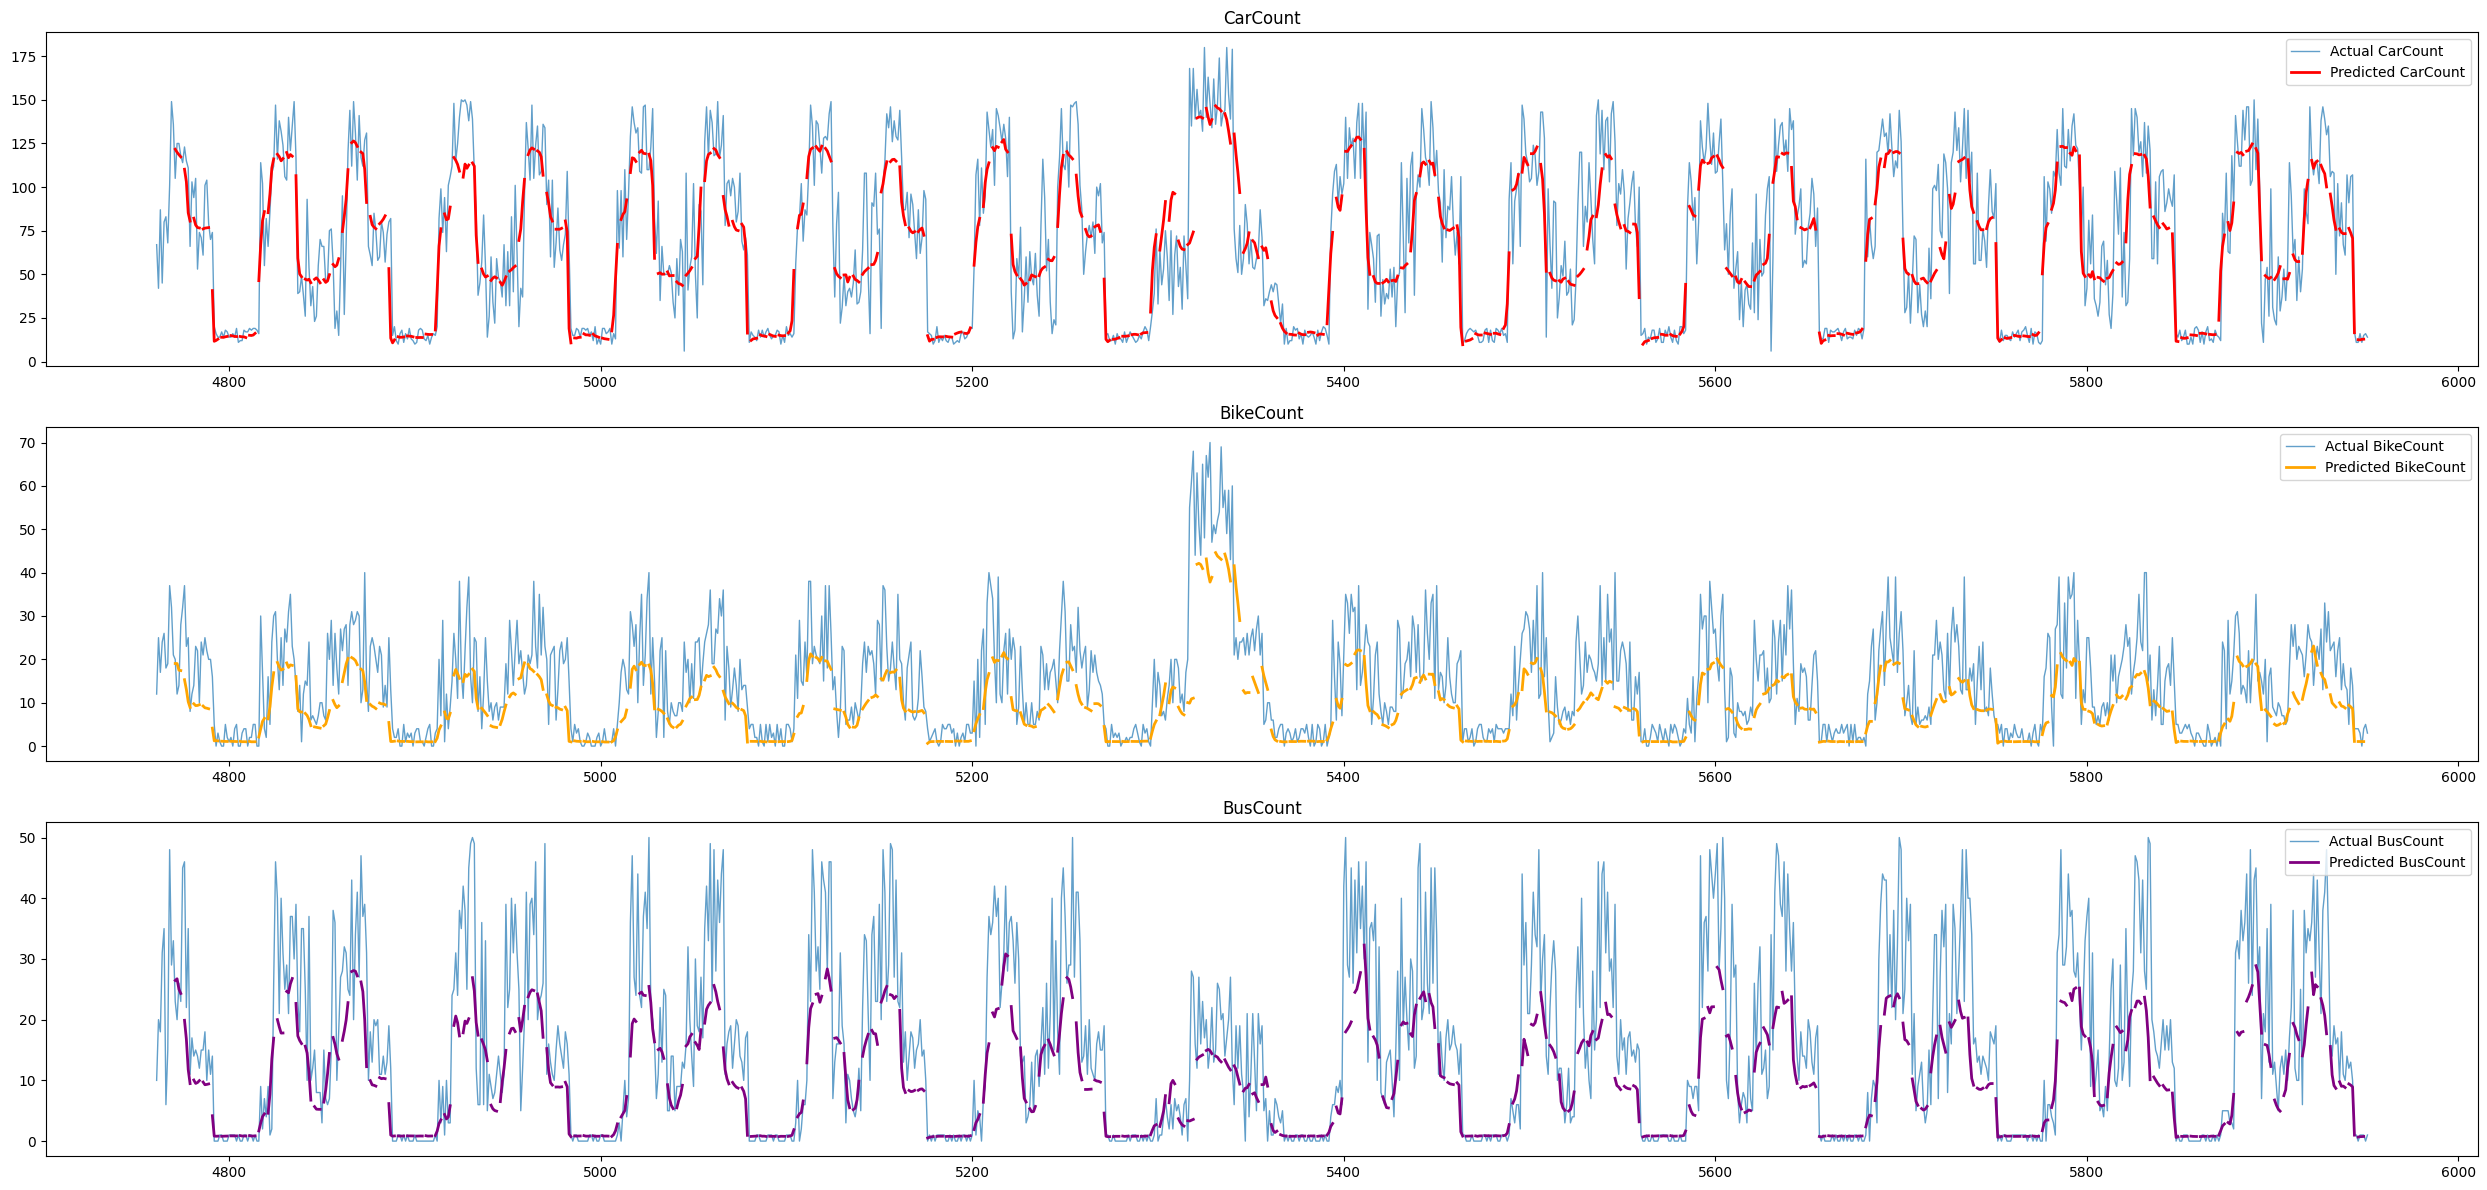

In [8]:
y_orig = test[['CarCount', 'BikeCount', 'BusCount']]
time = test.index

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12))

def show_prediction(ax, time, data, col, color, pred_x, pred_y):
        ax.plot(time, data[col], 
                linewidth=1,
                alpha=0.7,
                label=f'Actual {col}')
        ax.plot(pred_x, pred_y, 
                linewidth=2,
                color=color,
                label=f'Predicted {col}')
        ax.set_title(col)
        ax.legend()

show_prediction(ax1, time, y_orig, 'CarCount', 'r', pred_data[:, 0], pred_data[:, 1])
show_prediction(ax2, time, y_orig, 'BikeCount', 'orange', pred_data[:, 0],  pred_data[:, 2])
show_prediction(ax3, time, y_orig, 'BusCount',  'purple', pred_data[:, 0], pred_data[:, 3])

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

metrics = {
    'SMAPE': lambda y_true, y_pred: 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e+07)),
    'MAE': mean_absolute_error,
    'RMSE': root_mean_squared_error,
    'MAD': lambda y_true, y_pred: np.median(np.abs(y_true - y_pred))
}

In [10]:
y_pred = []

y_test_start = test.index[optimal_lag]
y_test_end = test.index[-1]
horizon = 4

for index in range(y_test_start, y_test_end + 1, horizon):
    start_time = get_time(index)
    prev_endog, prev_exog = get_prev_data(index, optimal_lag)
    future_exog = get_future_exog(start_time, horizon)
    predictions = predict(prev_endog, prev_exog, future_exog, horizon)
    y_pred.append(predictions)

y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [11]:
from numpy.lib.stride_tricks import sliding_window_view
y_orig_horizon = np.squeeze(sliding_window_view(test[endog_cols].loc[y_test_start: y_test_end].values, window_shape=(horizon, len(endog_cols))), 1)

horizon_metrics = { metric: { endog: [] for endog in endog_cols } for metric in metrics.keys() }

for orig, pred in zip(y_orig_horizon, y_pred):
    for metric in horizon_metrics.keys():
        for index, feature in zip(range(0, len(endog_cols)), endog_cols):
            horizon_metrics[metric][feature].append(metrics[metric](orig[:, index], pred[:, index]))


for metric in horizon_metrics.keys():
    for feature in horizon_metrics[metric].keys():
        horizon_metrics[metric][feature] = np.mean(horizon_metrics[metric][feature])

In [12]:
horizon_metrics

{'SMAPE': {'CarCount': 0.0009878089375663852,
  'BikeCount': 0.00022486297996404157,
  'BusCount': 0.00028174842981141797},
 'MAE': {'CarCount': 49.39114064300382,
  'BikeCount': 11.243181134196552,
  'BusCount': 14.087469500363678},
 'RMSE': {'CarCount': 52.40561305510031,
  'BikeCount': 12.274820832787332,
  'BusCount': 15.198511697049883},
 'MAD': {'CarCount': 48.93139733011658,
  'BikeCount': 11.241290429858742,
  'BusCount': 13.778348133672733}}

1 LSTM DROPOUT DENSE DENSE
    l4
        128 0.2 64 3 A0.0001
            clean
            {'SMAPE': {'CarCount': 0.0010166283125199137,
            'BikeCount': 0.00023080804160750741,
            'BusCount': 0.0002778553047508546},
            'MAE': {'CarCount': 50.832124898897725,
            'BikeCount': 11.540436040635077,
            'BusCount': 13.892810022470934},
            'RMSE': {'CarCount': 54.4935983171399,
            'BikeCount': 12.731136546038941,
            'BusCount': 15.179284164969554},
            'MAD': {'CarCount': 51.10399793458465,
            'BikeCount': 11.475148458608844,
            'BusCount': 13.222785126042846}}
  
            std
            {'SMAPE': {'CarCount': 0.0009750285629395884,
            'BikeCount': 0.00022674713363263248,
            'BusCount': 0.00028008953543564793},
            'MAE': {'CarCount': 48.75208198304144,
            'BikeCount': 11.337389517950532,
            'BusCount': 14.004522463219278},
            'RMSE': {'CarCount': 52.694424680415416,
            'BikeCount': 12.611826392628203,
            'BusCount': 15.454254196794242},
            'MAD': {'CarCount': 48.81401867514489,
            'BikeCount': 11.343586686473564,
            'BusCount': 13.291512253800494}}
  
            sqrt
            {'SMAPE': {'CarCount': 0.000975860544968641,
            'BikeCount': 0.00022170328608272995,
            'BusCount': 0.00026159350223850996},
            'MAE': {'CarCount': 48.79368600749329,
            'BikeCount': 11.08519514375085,
            'BusCount': 13.079715879571518},
            'RMSE': {'CarCount': 52.77900363454883,
            'BikeCount': 12.432570621471276,
            'BusCount': 14.535291686154052},
            'MAD': {'CarCount': 49.040700464440675,
            'BikeCount': 10.965069353580475,
            'BusCount': 12.370559221946152}}

            log
            {'SMAPE': {'CarCount': 0.0009677897440963604,
            'BikeCount': 0.00021628488276701505,
            'BusCount': 0.0002563939686631108},
            'MAE': {'CarCount': 48.39014386730706,
            'BikeCount': 10.814272389315919,
            'BusCount': 12.819736905896024},
            'RMSE': {'CarCount': 52.30566820042245,
            'BikeCount': 12.273512225823115,
            'BusCount': 14.190953303953545},
            'MAD': {'CarCount': 48.5618730519442,
            'BikeCount': 10.636435219880518,
            'BusCount': 11.95784797378497}}
            
            weight
            {'SMAPE': {'CarCount': 0.0009678984533297906,
            'BikeCount': 0.00022412092344003021,
            'BusCount': 0.00028099822688953664},
            'MAE': {'CarCount': 48.39557862441812,
            'BikeCount': 11.206078494955229,
            'BusCount': 14.04995727019022},
            'RMSE': {'CarCount': 52.2676733020168,
            'BikeCount': 12.486429616108836,
            'BusCount': 15.494476539576613},
            'MAD': {'CarCount': 48.290124477156056,
            'BikeCount': 11.211346024634855,
            'BusCount': 13.342749426828934}}
            
        64 0.2 32 3  A0.0001
            std
            {'SMAPE': {'CarCount': 0.0009838125322120838,
            'BikeCount': 0.00022902878710474842,
            'BusCount': 0.0002800962813525738},
            'MAE': {'CarCount': 49.19129399165211,
            'BikeCount': 11.451472901657924,
            'BusCount': 14.004859763103843},
            'RMSE': {'CarCount': 53.125560182853036,
            'BikeCount': 12.716266484868607,
            'BusCount': 15.454519436863444},
            'MAD': {'CarCount': 49.02731304680741,
            'BikeCount': 11.430425024672642,
            'BusCount': 13.251557794893348}}
            
            sqrt
            {'SMAPE': {'CarCount': 0.0009657568289648149,
            'BikeCount': 0.00022222242516157253,
            'BusCount': 0.0002637783623106263},
            'MAE': {'CarCount': 48.28848989777917,
            'BikeCount': 11.11115169365134,
            'BusCount': 13.188959174508216},
            'RMSE': {'CarCount': 52.318446945024014,
            'BikeCount': 12.448230787411632,
            'BusCount': 14.672489271867995},
            'MAD': {'CarCount': 48.30221830278435,
            'BikeCount': 10.989218173011038,
            'BusCount': 12.498461708326468}}

            log
            {'SMAPE': {'CarCount': 0.0009697846252262433,
            'BikeCount': 0.00021915773570193247,
            'BusCount': 0.00025625645871687845},
            'MAE': {'CarCount': 48.48989292279186,
            'BikeCount': 10.957915830132146,
            'BusCount': 12.812861571125936},
            'RMSE': {'CarCount': 52.629129933830875,
            'BikeCount': 12.395864656307554,
            'BusCount': 14.213246549835942},
            'MAD': {'CarCount': 48.66094120396864,
            'BikeCount': 10.838094316213548,
            'BusCount': 11.90513340578041}}
            
        32 0.2 16 3  A0.0001
            std
            {'SMAPE': {'CarCount': 0.000983418982268347,
            'BikeCount': 0.00022689301542377793,
            'BusCount': 0.0002819562056094303},
            'MAE': {'CarCount': 49.171611248246776,
            'BikeCount': 11.344683231123343,
            'BusCount': 14.09785609677334},
            'RMSE': {'CarCount': 53.12213762494542,
            'BikeCount': 12.579130119925377,
            'BusCount': 15.488384620855319},
            'MAD': {'CarCount': 49.15685161168143,
            'BikeCount': 11.337359314796908,
            'BusCount': 13.382062862383439}}

            sqrt
            {'SMAPE': {'CarCount': 0.0009680383331371032,
            'BikeCount': 0.0002210505634325393,
            'BusCount': 0.0002649350155390628},
            'MAE': {'CarCount': 48.40256332231048,
            'BikeCount': 11.052558338082077,
            'BusCount': 13.24679202221384},
            'RMSE': {'CarCount': 52.418339484490005,
            'BikeCount': 12.371772850119827,
            'BusCount': 14.710777941566185},
            'MAD': {'CarCount': 48.19951028631838,
            'BikeCount': 10.948577381020424,
            'BusCount': 12.564075227951843}}

            log
            {'SMAPE': {'CarCount': 0.000988550394369403,
            'BikeCount': 0.00022023820541034004,
            'BusCount': 0.00025735922595415906},
            'MAE': {'CarCount': 49.42819600937351,
            'BikeCount': 11.011939202379061,
            'BusCount': 12.868000167178227},
            'RMSE': {'CarCount': 53.340599216870814,
            'BikeCount': 12.413056948841017,
            'BusCount': 14.251451334897304},
            'MAD': {'CarCount': 49.24242075657685,
            'BikeCount': 10.876349950396774,
            'BusCount': 12.084955924409348}}

    l5
        128 0.2 64 3 A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.0009799101524730926,
        'BikeCount': 0.00022911585351281794,
        'BusCount': 0.00026180444444434594},
        'MAE': {'CarCount': 48.996180422354065,
        'BikeCount': 11.455826340105709,
        'BusCount': 13.09026272764942},
        'RMSE': {'CarCount': 53.03553904302968,
        'BikeCount': 12.756443417312315,
        'BusCount': 14.549911369213321},
        'MAD': {'CarCount': 49.39088959661906,
        'BikeCount': 11.380096508952596,
        'BusCount': 12.389189276319222}}

        log
        {'SMAPE': {'CarCount': 0.0009862167914886735,
        'BikeCount': 0.00022710491481704823,
        'BusCount': 0.0002639428943532201},
        'MAE': {'CarCount': 49.3115152592627,
        'BikeCount': 11.355276451014833,
        'BusCount': 13.197184176077979},
        'RMSE': {'CarCount': 53.47084382796447,
        'BikeCount': 12.752658964803555,
        'BusCount': 14.617143964369925},
        'MAD': {'CarCount': 49.7424030815995,
        'BikeCount': 11.301019100897364,
        'BusCount': 12.5620491398993}}

        64 0.2 32 3  A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.000980217968104399,
        'BikeCount': 0.00022431058164250223,
        'BusCount': 0.00026486935077593726},
        'MAE': {'CarCount': 49.01156620851299,
        'BikeCount': 11.215560659466174,
        'BusCount': 13.243508852768265},
        'RMSE': {'CarCount': 52.92939752860357,
        'BikeCount': 12.502442001496386,
        'BusCount': 14.692242469963611},
        'MAD': {'CarCount': 49.51197518918338,
        'BikeCount': 11.11284448196424,
        'BusCount': 12.571735458286017}}

        log
        {'SMAPE': {'CarCount': 0.0009899961481547174,
        'BikeCount': 0.0002205641865341878,
        'BusCount': 0.00025734186020705366},
        'MAE': {'CarCount': 49.50048666592412,
        'BikeCount': 11.0282387573447,
        'BusCount': 12.867131462308185},
        'RMSE': {'CarCount': 53.79348611191615,
        'BikeCount': 12.41089052721958,
        'BusCount': 14.297979778641423},
        'MAD': {'CarCount': 49.891133093993936,
        'BikeCount': 10.936084141617254,
        'BusCount': 12.115769258200272}}

    l10
        128 0.2 64 3 A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.0009562419145547746,
        'BikeCount': 0.00022934636988085718,
        'BusCount': 0.0002762916695366128},
        'MAE': {'CarCount': 47.812747581585036,
        'BikeCount': 11.467350774520153,
        'BusCount': 13.814626885024277},
        'RMSE': {'CarCount': 53.33133687199773,
        'BikeCount': 12.966242557441866,
        'BusCount': 15.462562378596616},
        'MAD': {'CarCount': 46.48110289831419,
        'BikeCount': 11.32937395391432,
        'BusCount': 13.133463380908644}}
  
        log
        {'SMAPE': {'CarCount': 0.0009756658815680064,
        'BikeCount': 0.0002234297566221816,
        'BusCount': 0.0002511401721917468},
        'MAE': {'CarCount': 48.783968745051205,
        'BikeCount': 11.17151818645967,
        'BusCount': 12.557045858051326},
        'RMSE': {'CarCount': 54.1825750582927,
        'BikeCount': 12.617355068793168,
        'BusCount': 14.190724404277029},
        'MAD': {'CarCount': 48.0911065114511,
        'BikeCount': 11.196086401761686,
        'BusCount': 11.88906386400671}}

        64 0.2 32 3  A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.0009825979410212837,
        'BikeCount': 0.0002270199286843813,
        'BusCount': 0.00026190370038796726},
        'MAE': {'CarCount': 49.13057099484109,
        'BikeCount': 11.351028598643637,
        'BusCount': 13.095225165220532},
        'RMSE': {'CarCount': 54.482061162188245,
        'BikeCount': 12.801065860567865,
        'BusCount': 14.66095610929502},
        'MAD': {'CarCount': 48.84778890738616,
        'BikeCount': 11.298885216181343,
        'BusCount': 12.569382155465114}}

        log
        {'SMAPE': {'CarCount': 0.000962271036290203,
        'BikeCount': 0.00021953742005738306,
        'BusCount': 0.0002502413265004853},
        'MAE': {'CarCount': 48.11421065233849,
        'BikeCount': 10.976900363290632,
        'BusCount': 12.512103166129139},
        'RMSE': {'CarCount': 53.50742819341453,
        'BikeCount': 12.401727475830027,
        'BusCount': 14.061457274330628},
        'MAD': {'CarCount': 47.46856191995982,
        'BikeCount': 10.991807522302544,
        'BusCount': 11.81378935102013}}

    l29
        128 0.2 64 3 A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.0010090259201194062,
        'BikeCount': 0.00021774095531189213,
        'BusCount': 0.00028844001730277027},
        'MAE': {'CarCount': 50.45201871982992,
        'BikeCount': 10.887079996605442,
        'BusCount': 14.422049292554593},
        'RMSE': {'CarCount': 55.52182931932685,
        'BikeCount': 12.354422017319562,
        'BusCount': 16.056268967381897},
        'MAD': {'CarCount': 51.87153519343023,
        'BikeCount': 10.370612937906017,
        'BusCount': 14.40507342716781}}
        
        log
        {'SMAPE': {'CarCount': 0.0010034747975700602,
        'BikeCount': 0.0002111967001301968,
        'BusCount': 0.00027487079888231715},
        'MAE': {'CarCount': 50.174456836426096,
        'BikeCount': 10.55986420748985,
        'BusCount': 13.743584912525465},
        'RMSE': {'CarCount': 55.52244862301709,
        'BikeCount': 12.195673135045457,
        'BusCount': 15.436541715917523},
        'MAD': {'CarCount': 52.12581884044491,
        'BikeCount': 10.001134165396838,
        'BusCount': 13.385383201686798}}

        64 0.2 32 3  A0.0001
        sqrt
        {'SMAPE': {'CarCount': 0.0009969510802923989,
        'BikeCount': 0.0002177063480437706,
        'BusCount': 0.00029185769113634506},
        'MAE': {'CarCount': 49.84826126163953,
        'BikeCount': 10.885348883393693,
        'BusCount': 14.592933869525178},
        'RMSE': {'CarCount': 54.904619461869544,
        'BikeCount': 12.328012268020682,
        'BusCount': 16.178615986892623},
        'MAD': {'CarCount': 51.561401811364576,
        'BikeCount': 10.353966682332835,
        'BusCount': 14.490739242671287}}

        log
        {'SMAPE': {'CarCount': 0.0009921684813334769,
        'BikeCount': 0.00020489646384692936,
        'BusCount': 0.0002760919053219378},
        'MAE': {'CarCount': 49.60912282417898,
        'BikeCount': 10.244851283831139,
        'BusCount': 13.804640179831688},
        'RMSE': {'CarCount': 54.64334751318579,
        'BikeCount': 11.875169128587801,
        'BusCount': 15.457177161149783},
        'MAD': {'CarCount': 51.43229035155414,
        'BikeCount': 9.60595898547095,
        'BusCount': 13.406893644660506}}



2 LSTM DROPOUT LSTM DROPOUT DENSE DENSE

sqrt

l4
    128 64 64
    sqrt
    {'SMAPE': {'CarCount': 0.0009861346601705736,
  'BikeCount': 0.00022308252840612277,
  'BusCount': 0.00026842031236104876},
 'MAE': {'CarCount': 49.307398632868825,
  'BikeCount': 11.154157276121563,
  'BusCount': 13.421057677509001},
 'RMSE': {'CarCount': 53.86883402750796,
  'BikeCount': 12.558306874844853,
  'BusCount': 14.979638228080416},
 'MAD': {'CarCount': 50.00837126674268,
  'BikeCount': 11.09992041143795,
  'BusCount': 12.760674144997692}}
  
    64 32 32
    sqrt
    {'SMAPE': {'CarCount': 0.000964484955949622,
  'BikeCount': 0.00021960411728387996,
  'BusCount': 0.0002654664168667356},
 'MAE': {'CarCount': 48.22489908957641,
  'BikeCount': 10.980235854251273,
  'BusCount': 13.273362080522832},
 'RMSE': {'CarCount': 52.7476738243295,
  'BikeCount': 12.36405226288226,
  'BusCount': 14.820352470314743},
 'MAD': {'CarCount': 49.09039379286286,
  'BikeCount': 10.931135453233782,
  'BusCount': 12.684551426628293}}
l5    
    128 64 64
    sqrt
    {'SMAPE': {'CarCount': 0.000989538499552901,
    'BikeCount': 0.0002292593015812858,
    'BusCount': 0.0002695427656803786},
    'MAE': {'CarCount': 49.47759679019851,
    'BikeCount': 11.462997946163151,
    'BusCount': 13.477180427752884},
    'RMSE': {'CarCount': 53.899634999716845,
    'BikeCount': 12.799801224830167,
    'BusCount': 15.057114921160192},
    'MAD': {'CarCount': 49.48379877269668,
    'BikeCount': 11.304719008255326,
    'BusCount': 12.859297414954076}}

    64 32 32
    sqrt
    {'SMAPE': {'CarCount': 0.0009721655306767097,
  'BikeCount': 0.00022970704018165298,
  'BusCount': 0.0002744984497669053},
 'MAE': {'CarCount': 48.60894794272097,
  'BikeCount': 11.485384835492845,
  'BusCount': 13.724965319537477},
 'RMSE': {'CarCount': 53.061447436377506,
  'BikeCount': 12.785534810699872,
  'BusCount': 15.236518672648693},
 'MAD': {'CarCount': 48.77562380797111,
  'BikeCount': 11.313989227850165,
  'BusCount': 13.079230489446813}}
l10
    128 64 64
    sqrt
    {'SMAPE': {'CarCount': 0.0009744498478501655,
    'BikeCount': 0.00022906966797871313,
    'BusCount': 0.0002680820445941976},
    'MAE': {'CarCount': 48.723164342545175,
    'BikeCount': 11.453516005664259,
    'BusCount': 13.404143895450476},
    'RMSE': {'CarCount': 54.118146599950016,
    'BikeCount': 12.930736913068875,
    'BusCount': 14.984709520597715},
    'MAD': {'CarCount': 48.305104954822646,
    'BikeCount': 11.447010927506396,
    'BusCount': 12.866676757061803}}

    64 32 32
    sqrt
    {'SMAPE': {'CarCount': 0.0009482012561066301,
  'BikeCount': 0.00022309349964454592,
  'BusCount': 0.0002629647882013794},
 'MAE': {'CarCount': 47.41070764773601,
  'BikeCount': 11.15470626064249,
  'BusCount': 13.148279467949996},
 'RMSE': {'CarCount': 52.789752162791586,
  'BikeCount': 12.640166259295231,
  'BusCount': 14.739006823381862},
 'MAD': {'CarCount': 46.58377743411709,
  'BikeCount': 11.080335602969736,
  'BusCount': 12.472376175426149}}


MAE - Среднее отклонение (дельта) прогноза
MAPE -  Средний **процент** ошибки относительно фактических значений. (на сколько процентов в среднем ошибается модель относительно фактических значений). MAPE менее объективен при данных с большим разбросом или близких к нулю значениях.
MSE - Средняя квадратичная ошибка (квадрат дельты). Используем, когда большие отклонения нужно учитывать. (Когда данные - это не выброс, а аномалия)
RMSE - MSE стандартизированный
MAD Медианное абсолютное отклонение. Устойчива к выбросам
MASE - метрика для оценки качества прогноза временных рядов, которая сравнивает ошибку модели с ошибкой наивного прогноза (Завтрашнее значение = сегодняшнее)
SMASE - для временных рядов с сезонностью. Она сравнивает ошибку модели с ошибкой сезонного наивного прогноза (например, "сегодняшний трафик похож на трафик неделю назад").

6. Делаем воркера.
7. Делаем апи